# Imports

In [ ]:
import matplotlib
from google.colab import runtime

# Por defecto tiene matplotlib: 3.2.2
print('matplotlib: {}'.format(matplotlib.__version__))

if matplotlib.__version__ == '3.2.2':
    # Se necesita una versión > 3.5.1 que soporte float16 para pintar kanji
    !pip install -U matplotlib

    print('Stopping RUNTIME! Please run again.')
    quit()
    # https://twitter.com/GoogleColab/status/1569389018311426051

matplotlib: 3.7.0


In [ ]:
# track time of each cell
!pip install ipython-autotime
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
time: 389 µs (started: 2023-02-22 10:31:31 +00:00)


In [ ]:
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, subplots, show
import PIL as pil
import skimage.transform
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix
)
from tensorflow import keras
from keras.layers import (
    Conv2D, MaxPool2D, Flatten, Dense,
    Dropout, Input, Concatenate, GlobalAveragePooling2D
)
from keras.models import Model
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from google.colab import drive

time: 3.49 s (started: 2023-02-22 10:31:31 +00:00)


In [ ]:
CHANNEL = 1
DATA_REPR = 'float32' # Antes era 'uint8'
NUM_CLASSES = 2965
ETL_DATASET = 'etl_9G'
DNN_NAME = 'DenseNet121'

USE_DATA_AUG = 'sin_DA' # o también con_DA
TYPE_IMG = 'inverted' 

TFM_PATH = '/content/gdrive/MyDrive/Master_IA/TFM/'
ROOT_PATH = TFM_PATH + 'datasets/'+ ETL_DATASET +'/uint32/imgs_{}/splits/' \
            + TYPE_IMG +'_otsu/'

print(ROOT_PATH)
print()
print('versión Keras:', keras.__version__)

/content/gdrive/MyDrive/Master_IA/TFM/datasets/etl_9G/uint32/imgs_{}/splits/inverted_otsu/

versión Keras: 2.11.0
time: 1.3 ms (started: 2023-02-22 10:31:35 +00:00)


In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive
time: 19.8 s (started: 2023-02-22 10:31:35 +00:00)


# Funciones

In [ ]:
def load_images_for_training(DATA_REPR, PATH, TYPE_IMG):
    '''
    Load images for training and validation with their labels

    Args:

    - DATA_REPR: Representation of numpy data. Ex: uint8, float32
    - ROOT_PATH: Path in Google Drive where imgs and labels are stored

    Output:
    - np arrays for training and validation images
    '''
    if TYPE_IMG == 'regular':
        train_name_img = 'train_imgs_9G.npz'
        train_name_labels = 'train_labels_9G.npz'
        val_name_img = 'val_imgs_9G.npz'
        val_name_labels = 'val_labels_9G.npz'
    elif TYPE_IMG == 'inverted':
        train_name_img = 'train_inv_imgs_9G.npz'
        train_name_labels = 'train_inv_labels_9G.npz'
        val_name_img = 'val_inv_imgs_9G.npz'
        val_name_labels = 'val_inv_labels_9G.npz'

    train_images = np.load(PATH+train_name_img)['arr_0']
    train_labels = np.load(PATH+train_name_labels)['arr_0'].astype(DATA_REPR)

    val_images = np.load(PATH+val_name_img)['arr_0']
    val_labels = np.load(PATH+val_name_labels)['arr_0'].astype(DATA_REPR)

    return train_images, train_labels, val_images, val_labels


def load_test_images(DATA_REPR, PATH, TYPE_IMG):
    '''
    Load images for training and validation with their labels

    Args:

    - DATA_REPR: Representation of numpy data. Ex: uint8, float32
    - ROOT_PATH: Path in Google Drive where imgs and labels are stored

    Output:
    - np arrays for testing images
    '''

    if TYPE_IMG == 'regular':
        test_name_img = 'test_imgs_9G.npz'
        test_name_labels = 'test_labels_9G.npz'
    elif TYPE_IMG == 'inverted':
        test_name_img = 'test_inv_imgs_9G.npz'
        test_name_labels = 'test_inv_labels_9G.npz'

    test_images = np.load(PATH+test_name_img)['arr_0']
    test_labels = np.load(PATH+test_name_labels)['arr_0'].astype(DATA_REPR)

    return test_images, test_labels


def create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL):

    image_input = Input(shape=(WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL))
    img_conc = Concatenate()([image_input, image_input, image_input])

    m_DenseNet121_9G = keras.applications.DenseNet121(
        include_top=False,
        input_tensor=img_conc,
        weights='imagenet',
    )

    last_layer = m_DenseNet121_9G.layers[-1].output
    x = GlobalAveragePooling2D()(last_layer)
    out = Dense(NUM_CLASSES, activation='softmax', name='predictions')(x)
    custom_model = Model(image_input, out)

    # freeze all the layers except the 2 newly added layers
    for layer in custom_model.layers[:-2]:
        layer.trainable = False

    return custom_model


def train_model(custom_model, train_images, train_labels, val_images, val_labels):

    callback = EarlyStopping(
        monitor='val_sparse_categorical_accuracy',
        patience=5,
        verbose=1
    )

    custom_model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=Adam(learning_rate=0.0001),
        metrics=["sparse_categorical_accuracy"]
    )

    history = custom_model.fit(
        train_images,
        train_labels,
        validation_data=(val_images, val_labels),
        epochs= 50, # en 2022 usé 20 epochs
        callbacks = [callback],
        # verbose = 1,
        # batch_size=32
    )

    print('--- Iterations ended ---')
    print()
    print()

    return history


def show_metrics(custom_model, test_images, test_labels):
    test_loss, test_accuracy = custom_model.evaluate(test_images, test_labels)
    y_pred = np.argmax(custom_model.predict(test_images), axis=1)

    print("*********************************************************************************************************************************")
    print()
    print("- Test Accuracy:", test_accuracy)
    print("- Test Loss:", test_loss)
    print("- time: ")
    print("- F1 score:", f1_score(test_labels, y_pred, average='weighted'))
    print("- Precision score:", precision_score(test_labels, y_pred, average='weighted'))
    print("- Recall: ", recall_score(test_labels, y_pred, average='weighted'))
    print("- Epoch: ")
    print("*********************************************************************************************************************************")


def plot_loss(history):
    pd.DataFrame(history.history).plot(figsize=(7,5))
    plt.grid(True)
    plt.gca().set_ylim(0,2) # usualmente 0,5
    plt.show()


def show_history(history):
    #-----------------------------------------------------------
    # Recuperar una lista de resultados de la lista de datos de los conjuntos de entrenamiento y pruebas para cada epoch de entrenamiento
    #-----------------------------------------------------------

    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    #------------------------------------------------
    # Imprimir la precisión del entrenamiento y validación por epoch
    #------------------------------------------------
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Precisión de entrenamiento y validación')
    plt.legend()
    plt.grid()
    plt.figure()

    #------------------------------------------------
    # Imprimir la perdida de entrenamiento y validación por epoch
    #------------------------------------------------
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Perdida de entrenamiento y validación')
    plt.legend()
    plt.grid()
    plt.show()


def save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, DNN_NAME, USE_DATA_AUG):
    '''Guardar el modelo en disco duro
    
    Args:
        - SIZE: 64, 96, 112 ó 127
        - TFM_PATH = Ruta en drive a la carpeta del TFM
        - custom_model = Modelo de Deep Learning
        - TYPE_IMG = regular o inverted
        - USE_DATA_AUG = sin_DA o con_DA
        - DNN_NAME= Deep Neural Network's name, like DenseNet121.
    ''' 
    MODEL_NAME = f'model_{DNN_NAME.lower()}_etl9_imgs{SIZE}_' \
                + TYPE_IMG +'__OTSU.h5'

    WEIGHTS_PATH = TFM_PATH + 'notebooks/arqs_2023/' \
                + DNN_NAME + f'/weights_{DNN_NAME.lower()}/' \
                + USE_DATA_AUG +'/'+ TYPE_IMG +'/' + MODEL_NAME

    custom_model.save(WEIGHTS_PATH)

    print(f'------ Model Saved in {WEIGHTS_PATH}')


time: 7.2 ms (started: 2023-02-22 10:32:16 +00:00)


# Imgs 64x64

- Test Accuracy: 0.527453601360321
- Test Loss: 2.526777505874634
- time: 4h 12min 41s
- F1 score: 0.527658107201612
- Precision score: 0.5550638466899308
- Recall:  0.5274536256323777
- Epoch: 50/50


## Cargar la imágenes

In [ ]:
SIZE = 64  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

print(PATH)

/content/gdrive/MyDrive/Master_IA/TFM/datasets/etl_9G/uint32/imgs_64/splits/inverted_otsu/
time: 689 µs (started: 2023-02-21 20:53:19 +00:00)


In [ ]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 9.12 s (started: 2023-02-21 20:53:20 +00:00)


In [ ]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()
print()

- train images: (444750, 64, 64, 1) and labels: (444750,)

- val images: (88950, 64, 64, 1) and labels: (88950,)


time: 1.17 ms (started: 2023-02-21 20:53:29 +00:00)


## Preparar el modelo

In [ ]:
custom_model = create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL)

29084464/29084464 [==============================] - 0s 0us/step
time: 6.87 s (started: 2023-02-21 20:53:29 +00:00)


In [ ]:
print(custom_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 64, 64, 3)    0           ['input_1[0][0]',                
                                                                  'input_1[0][0]',                
                                                                  'input_1[0][0]']                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)   0           ['concatenate[0][0]']            
                                                                                              

## Entrenar modelo

In [ ]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
13899/13899 [==============================] - 309s 21ms/step - loss: 6.4030 - sparse_categorical_accuracy: 0.0839 - val_loss: 5.5779 - val_sparse_categorical_accuracy: 0.1620
Epoch 2/50
13899/13899 [==============================] - 291s 21ms/step - loss: 5.0203 - sparse_categorical_accuracy: 0.2302 - val_loss: 4.8013 - val_sparse_categorical_accuracy: 0.2468
Epoch 3/50
13899/13899 [==============================] - 290s 21ms/step - loss: 4.3357 - sparse_categorical_accuracy: 0.3119 - val_loss: 4.3354 - val_sparse_categorical_accuracy: 0.2984
Epoch 4/50
13899/13899 [==============================] - 290s 21ms/step - loss: 3.8803 - sparse_categorical_accuracy: 0.3672 - val_loss: 4.0132 - val_sparse_categorical_accuracy: 0.3322
Epoch 5/50
13899/13899 [==============================] - 290s 21ms/step - loss: 3.5474 - sparse_categorical_accuracy: 0.4080 - val_loss: 3.7747 - val_sparse_categorical_accuracy: 0.3617
Epoch 6/50
13899/13899 [==============================] - 302s 22

In [ ]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 1.28 s (started: 2023-02-22 01:06:19 +00:00)


In [ ]:
show_metrics(custom_model, test_images, test_labels)

1854/1854 [==============================] - 33s 17ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.527453601360321
- Test Loss: 2.526777505874634
- time: 
- F1 score: 0.527658107201612
- Precision score: 0.5550638466899308
- Recall:  0.5274536256323777
- Epoch: 
*********************************************************************************************************************************
time: 1min 11s (started: 2023-02-22 01:06:20 +00:00)


## Graficando

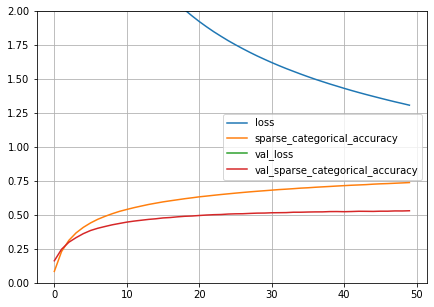

time: 266 ms (started: 2023-02-22 01:07:32 +00:00)


In [ ]:
plot_loss(history)

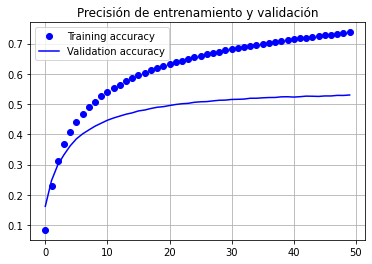

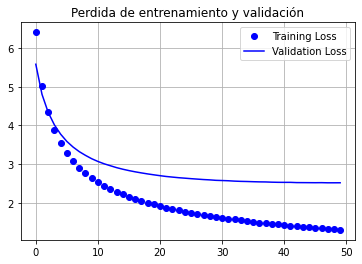

time: 568 ms (started: 2023-02-22 01:07:32 +00:00)


In [ ]:
show_history(history)

In [ ]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, DNN_NAME, USE_DATA_AUG)

------ Model Saved in /content/gdrive/MyDrive/Master_IA/TFM/notebooks/arqs_2023/DenseNet121/weights_densenet121/sin_DA/inverted/model_densenet121_etl9_imgs64_inverted__OTSU.h5
time: 1.82 s (started: 2023-02-22 01:07:32 +00:00)


# Imgs 96x96

- Test Accuracy: 0.5842664241790771
- Test Loss: 2.1829233169555664
- time: 4h 16min 7s
- F1 score: 0.5849469747245354
- Precision score: 0.6088976557366673
- Recall:  0.5842664418212479
- Epoch: 50/50


## Cargar las imágenes

In [ ]:
SIZE = 96  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

print(PATH)

/content/gdrive/MyDrive/Master_IA/TFM/datasets/etl_9G/uint32/imgs_96/splits/inverted_otsu/
time: 1.23 ms (started: 2023-02-22 10:32:30 +00:00)


In [ ]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 16.3 s (started: 2023-02-22 10:32:31 +00:00)


In [ ]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()

- train images: (444750, 96, 96, 1) and labels: (444750,)

- val images: (88950, 96, 96, 1) and labels: (88950,)

time: 1.27 ms (started: 2023-02-22 10:32:47 +00:00)


## Preparar el modelo

In [ ]:
custom_model = create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL)

29084464/29084464 [==============================] - 0s 0us/step
time: 7.02 s (started: 2023-02-22 10:32:47 +00:00)


In [ ]:
print(custom_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 1)]  0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 96, 96, 3)    0           ['input_1[0][0]',                
                                                                  'input_1[0][0]',                
                                                                  'input_1[0][0]']                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 102, 102, 3)  0          ['concatenate[0][0]']            
                                                                                              

## Entrenar modelo

In [ ]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
13899/13899 [==============================] - 332s 23ms/step - loss: 6.4900 - sparse_categorical_accuracy: 0.0909 - val_loss: 5.6786 - val_sparse_categorical_accuracy: 0.1693
Epoch 2/50
13899/13899 [==============================] - 312s 22ms/step - loss: 5.1295 - sparse_categorical_accuracy: 0.2436 - val_loss: 4.8821 - val_sparse_categorical_accuracy: 0.2622
Epoch 3/50
13899/13899 [==============================] - 308s 22ms/step - loss: 4.4321 - sparse_categorical_accuracy: 0.3296 - val_loss: 4.3874 - val_sparse_categorical_accuracy: 0.3169
Epoch 4/50
13899/13899 [==============================] - 307s 22ms/step - loss: 3.9603 - sparse_categorical_accuracy: 0.3870 - val_loss: 4.0395 - val_sparse_categorical_accuracy: 0.3539
Epoch 5/50
13899/13899 [==============================] - 308s 22ms/step - loss: 3.6103 - sparse_categorical_accuracy: 0.4300 - val_loss: 3.7775 - val_sparse_categorical_accuracy: 0.3838
Epoch 6/50
13899/13899 [==============================] - 307s 22

In [ ]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 2.14 s (started: 2023-02-22 14:49:03 +00:00)


In [ ]:
show_metrics(custom_model, test_images, test_labels)

1854/1854 [==============================] - 33s 16ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.5842664241790771
- Test Loss: 2.1829233169555664
- time: 
- F1 score: 0.5849469747245354
- Precision score: 0.6088976557366673
- Recall:  0.5842664418212479
- Epoch: 
*********************************************************************************************************************************
time: 1min 10s (started: 2023-02-22 14:49:05 +00:00)


## Graficando

In [ ]:
plot_loss(history)

In [ ]:
show_history(history)

In [ ]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, DNN_NAME, USE_DATA_AUG)

------ Model Saved in /content/gdrive/MyDrive/Master_IA/TFM/notebooks/arqs_2023/DenseNet121/weights_densenet121/sin_DA/inverted/model_densenet121_etl9_imgs96_inverted__OTSU.h5
time: 2.55 s (started: 2023-02-22 14:50:16 +00:00)


# Imgs 112x112

- Test Accuracy: 0.6348060965538025
- Test Loss: 1.864793300628662
- time: 4h 14min 30s
- F1 score: 0.635901547498387
- Precision score: 0.6565952227950488
- Recall:  0.6348060708263069
- Epoch: 50/50

## Cargar imágenes

In [ ]:
SIZE = 112  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

print(PATH)

In [ ]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

In [ ]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()

## Preparar el modelo

In [ ]:
custom_model = create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL)

In [ ]:
print(custom_model.summary())

## Entrenar modelo


In [25]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
13899/13899 [==============================] - 304s 21ms/step - loss: 6.2064 - sparse_categorical_accuracy: 0.1269 - val_loss: 5.2535 - val_sparse_categorical_accuracy: 0.2284
Epoch 2/50
13899/13899 [==============================] - 297s 21ms/step - loss: 4.6309 - sparse_categorical_accuracy: 0.3159 - val_loss: 4.3566 - val_sparse_categorical_accuracy: 0.3334
Epoch 3/50
13899/13899 [==============================] - 306s 22ms/step - loss: 3.8715 - sparse_categorical_accuracy: 0.4093 - val_loss: 3.8334 - val_sparse_categorical_accuracy: 0.3939
Epoch 4/50
13899/13899 [==============================] - 306s 22ms/step - loss: 3.3818 - sparse_categorical_accuracy: 0.4701 - val_loss: 3.4730 - val_sparse_categorical_accuracy: 0.4350
Epoch 5/50
13899/13899 [==============================] - 306s 22ms/step - loss: 3.0317 - sparse_categorical_accuracy: 0.5140 - val_loss: 3.2152 - val_sparse_categorical_accuracy: 0.4638
Epoch 6/50
13899/13899 [==============================] - 307s 22

## Métricas


In [26]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 2.72 s (started: 2023-02-22 19:05:13 +00:00)


In [27]:
show_metrics(custom_model, test_images, test_labels)

1854/1854 [==============================] - 33s 17ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.6348060965538025
- Test Loss: 1.864793300628662
- time: 
- F1 score: 0.635901547498387
- Precision score: 0.6565952227950488
- Recall:  0.6348060708263069
- Epoch: 
*********************************************************************************************************************************
time: 1min 8s (started: 2023-02-22 19:05:16 +00:00)


## Graficando

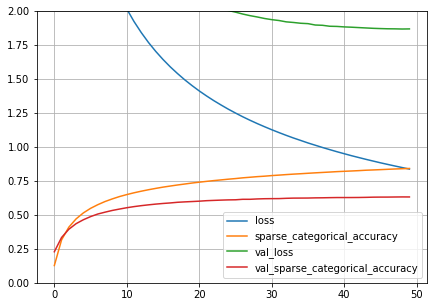

time: 195 ms (started: 2023-02-22 19:06:25 +00:00)


In [28]:
plot_loss(history)

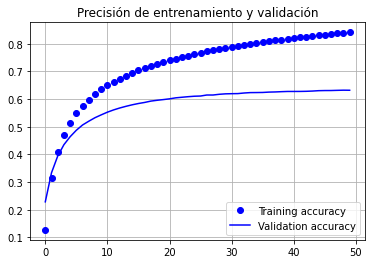

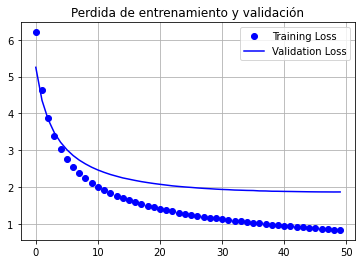

time: 377 ms (started: 2023-02-22 19:06:25 +00:00)


In [29]:
show_history(history)

In [30]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, DNN_NAME, USE_DATA_AUG)

------ Model Saved in /content/gdrive/MyDrive/Master_IA/TFM/notebooks/arqs_2023/DenseNet121/weights_densenet121/sin_DA/inverted/model_densenet121_etl9_imgs112_inverted__OTSU.h5
time: 932 ms (started: 2023-02-22 19:06:26 +00:00)


# Imgs 127x127

- Test Accuracy: 0.6858178973197937
- Test Loss: 1.536696434020996
- time: 4h 27min 6s
- F1 score: 0.687116203767364
- Precision score: 0.7064582036598898
- Recall:  0.6858178752107926
- Epoch: 50/50


## Cargar imágenes

In [31]:
SIZE = 127  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

print(PATH)

/content/gdrive/MyDrive/Master_IA/TFM/datasets/etl_9G/uint32/imgs_127/splits/inverted_otsu/
time: 744 µs (started: 2023-02-22 19:06:34 +00:00)


In [32]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 25.2 s (started: 2023-02-22 19:06:34 +00:00)


In [33]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()

- train images: (444750, 127, 127, 1) and labels: (444750,)

- val images: (88950, 127, 127, 1) and labels: (88950,)

time: 1.1 ms (started: 2023-02-22 19:06:59 +00:00)


## Preparar el modelo

In [34]:
custom_model = create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL)

time: 2.99 s (started: 2023-02-22 19:06:59 +00:00)


In [35]:
print(custom_model.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 127, 127, 1  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_2 (Concatenate)    (None, 127, 127, 3)  0           ['input_3[0][0]',                
                                                                  'input_3[0][0]',                
                                                                  'input_3[0][0]']                
                                                                                                  
 zero_padding2d_4 (ZeroPadding2  (None, 133, 133, 3)  0          ['concatenate_2[0][0]']    

## Entrenar modelo

In [36]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
13899/13899 [==============================] - 315s 22ms/step - loss: 6.0686 - sparse_categorical_accuracy: 0.1473 - val_loss: 4.9983 - val_sparse_categorical_accuracy: 0.2728
Epoch 2/50
13899/13899 [==============================] - 307s 22ms/step - loss: 4.3421 - sparse_categorical_accuracy: 0.3648 - val_loss: 4.0149 - val_sparse_categorical_accuracy: 0.3897
Epoch 3/50
13899/13899 [==============================] - 304s 22ms/step - loss: 3.5339 - sparse_categorical_accuracy: 0.4666 - val_loss: 3.4529 - val_sparse_categorical_accuracy: 0.4524
Epoch 4/50
13899/13899 [==============================] - 303s 22ms/step - loss: 3.0266 - sparse_categorical_accuracy: 0.5283 - val_loss: 3.0803 - val_sparse_categorical_accuracy: 0.4959
Epoch 5/50
13899/13899 [==============================] - 306s 22ms/step - loss: 2.6728 - sparse_categorical_accuracy: 0.5724 - val_loss: 2.8170 - val_sparse_categorical_accuracy: 0.5270
Epoch 6/50
13899/13899 [==============================] - 312s 22

## Graficando

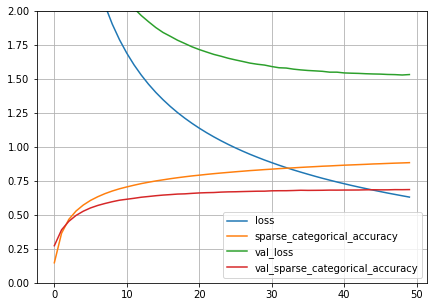

time: 227 ms (started: 2023-02-22 23:34:11 +00:00)


In [37]:
plot_loss(history)

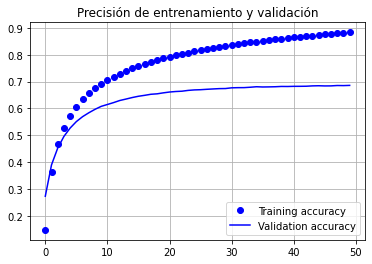

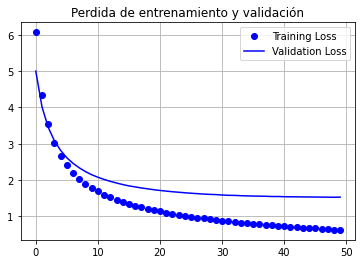

time: 383 ms (started: 2023-02-22 23:34:11 +00:00)


In [38]:
show_history(history)

In [39]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, DNN_NAME, USE_DATA_AUG)

------ Model Saved in /content/gdrive/MyDrive/Master_IA/TFM/notebooks/arqs_2023/DenseNet121/weights_densenet121/sin_DA/inverted/model_densenet121_etl9_imgs127_inverted__OTSU.h5
time: 936 ms (started: 2023-02-22 23:34:11 +00:00)


## Métricas

In [40]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 3.41 s (started: 2023-02-22 23:34:12 +00:00)


In [42]:
show_metrics(custom_model, test_images, test_labels)

1854/1854 [==============================] - 36s 18ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.6858178973197937
- Test Loss: 1.536696434020996
- time: 
- F1 score: 0.687116203767364
- Precision score: 0.7064582036598898
- Recall:  0.6858178752107926
- Epoch: 
*********************************************************************************************************************************
time: 1min 15s (started: 2023-02-22 23:39:35 +00:00)
